In [ ]:
from tensorflow import keras
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.models import load_model

import pickle
from pickle import dump, load

import numpy as np
from numpy import array
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input

import matplotlib.pyplot as plt
import matplotlib

#for use in beam search
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences


In [ ]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
inception_model = load_model('/content/drive/My Drive/Colab Notebooks/testing/inception.h5')

In [ ]:
caption_model = load_model('/content/drive/My Drive/Colab Notebooks/testing/caption_model.h5')

In [ ]:

with open('/content/drive/My Drive/Colab Notebooks/testing/vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)
with open('/content/drive/My Drive/Colab Notebooks/testing/ixtoword.pkl', 'rb') as f:
        ixtoword = pickle.load(f)
with open('/content/drive/My Drive/Colab Notebooks/testing/wordtoix.pkl', 'rb') as f:
        wordtoix = pickle.load(f)

print(len(vocab))
print(len(ixtoword))
print(len(wordtoix))
max_length = 34
vocab_size = 1652
embedding_dim = 200


1651
1651
1651


In [ ]:
#import - np, numpy.array, from keras.preprocessing import image,from keras.applications.inception_v3 import preprocess_input

def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [ ]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = inception_model.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
def beam_search_predictions(photo, index = 3):
    start = [wordtoix['startseq']]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            #e = encoding_test[photo[len(images):]]
            preds = caption_model.predict([photo, np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

group of students are posing for picture


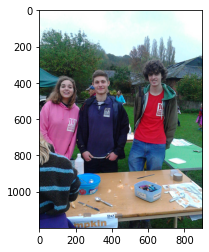

In [ ]:
image_path = "/content/drive/My Drive/Colab Notebooks/testing/image/sample_3.jpg"
encoded_image = encode(image_path)
# print(encoded_image)
encoded_image = encoded_image.reshape((1,2048)) 
caption = beam_search_predictions(encoded_image, index = 3)
print(caption)
x=plt.imread(image_path)
plt.imshow(x)
plt.show()
# des=os.path.splitext(pic)[0]
# print(des)